  # **Capstone project: Providing data-driven suggestions for HR**

## Description and deliverables

This capstone project is an opportunity for you to analyze a dataset and build predictive models that can provide insights to the Human Resources (HR) department of a large consulting firm.

Upon completion, you will have two artifacts that you would be able to present to future employers. One is a brief one-page summary of this project that you would present to external stakeholders as the data professional in Salifort Motors. The other is a complete code notebook provided here. Please consider your prior course work and select one way to achieve this given project question. Either use a regression model or machine learning model to predict whether or not an employee will leave the company. The exemplar following this actiivty shows both approaches, but you only need to do one.

In your deliverables, you will include the model evaluation (and interpretation if applicable), a data visualization(s) of your choice that is directly related to the question you ask, ethical considerations, and the resources you used to troubleshoot and find answers or solutions.


# **PACE stages**


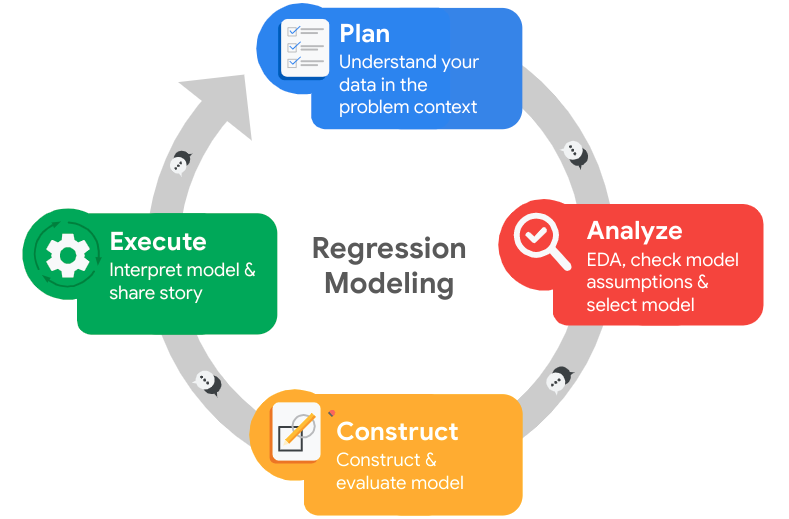

## **Pace: Plan**

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following:

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Familiarize yourself with the HR dataset

The dataset that you'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** you don't need to download any data to complete this lab. For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

💭
### Reflect on these questions as you complete the plan stage.

*  Who are your stakeholders for this project?
- What are you trying to solve or accomplish?
- What are your initial observations when you explore the data?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?




[Double-click to enter your responses here.]

## Step 1. Imports

*   Import packages
*   Load dataset



### Import packages

In [138]:
# Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, fixed

import plotly.express as px

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, f1_score,\
roc_auc_score, RocCurveDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle as pkl
import statsmodels.api as sm

### Load dataset

`Pandas` is used to read a dataset called **`HR_capstone_dataset.csv`.**  As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [3]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")


# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Functions

Space for defining some reused functions.

In [172]:
def model_evaluator(model_name, y_true, y_pred, y_proba):
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred) 
    auc = roc_auc_score(y_true, y_proba)
    
    # Create table of results
    table = pd.DataFrame({'Model' : [model_name],
                        'Recall' : [recall],
                        'Auc' : [auc],
                        'F1' : [f1],
                        'Precision' : [precision],
                        'Accuracy' : [accuracy]
                        })
                         
    return table

In [183]:
def model_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the recall, precision, f1 and accuracy scores
    for the model with the best mean recall score across all validation folds.  
    '''
    
    # Get all the results from the CV and put them in a df    
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = cv_results['mean_test_f1'][model_object.best_index_]
    recall = cv_results['mean_test_recall'][model_object.best_index_]
    precision = cv_results['mean_test_precision'][model_object.best_index_]
    accuracy = cv_results['mean_test_accuracy'][model_object.best_index_]
    auc = cv_results['mean_test_roc_auc'][model_object.best_index_]
    
    # Create table of results
    table = pd.DataFrame({'Model' : [model_name],
                        'Recall' : [recall],
                          'Auc' : [auc],
                          'F1': [f1],
                        'Precision' : [precision],
                        'Accuracy' : [accuracy]  
                        })
    
    return (table, cv_results)

## Step 2. Data Exploration (Initial EDA and data cleaning)

- Understand your variables
- Clean your dataset (missing data, redundant data, outliers)



### Gather basic information about the data

In [6]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [7]:
df0.shape

(14999, 10)

### Gather descriptive statistics about the data

In [8]:
# Gather descriptive statistics about the data
df0.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


<span style="color:red">**Observations:**</span> Although there are neither abnormal values nor null entries in this dataset, a maximum of 310 working hours per month implies 77.5 hours per week—almost double the standard 40-hour workweek in the United States. This could be a key factor to consider when analysing the likelihood of employees leaving the company.

It’s also interesting to note that the oldest employee has been with the company for only 10 years. Compared to the average working time required to reach retirement (at least 25 years), this suggests very limited long-term stability within the organisation.

### Rename columns

As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [9]:
# Display all column names
# Done above

In [10]:
# Rename columns as needed
df0 = df0.rename({'Work_accident' : 'work_accident',
            'Department' : 'department',
                  'average_montly_hours' : 'average_monthly_hours'
           }, axis=1)

# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [11]:
# Check for missing values
# Done above

<span style="color:red">**Observations:**</span>
* Columns were renamed according to snake_case and misspellings were corrected.
* There are not null values in this data set.

### Check duplicates

Check for any duplicate entries in the data.

In [12]:
# Check for duplicates
df0[df0.duplicated()]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [13]:
df0[df0.duplicated()].shape[0]/df0.shape[0]

0.2005467031135409

<span style="color:red">**Observations:**</span> 20 % of the data is duplicated, that is a big amount. Why is that information duplicated? People answered the poll more than once? Why was that possible?


In [14]:
# Inspect some rows containing duplicates as needed
# Done above

In [15]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates().reset_index(drop=True)

# Display first few rows of new dataframe as needed
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [16]:
# Verify number of columns after removing duplicates
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 936.9+ KB


In [17]:
df1.shape

(11991, 10)

<span style="color:red">**Observations:**</span> Since we needed to delete those duplicates, the data set is now reduced to (11991, 10) entries.

In [18]:
# Departments, their names and employees distribution in them.
df1['department'].value_counts()

sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: department, dtype: int64

In [19]:
# Percentage of employees distributed by department
df1['department'].value_counts(normalize=True)

sales          0.270119
technical      0.187140
support        0.151864
IT             0.081394
RandD          0.057877
product_mng    0.057210
marketing      0.056125
accounting     0.051789
hr             0.050121
management     0.036361
Name: department, dtype: float64

In [20]:
# Salary categories and employees distribution in them
df1['salary'].value_counts()

low       5740
medium    5261
high       990
Name: salary, dtype: int64

In [21]:
# Percentage of employees distributed by salary level
df1['salary'].value_counts(normalize=True)

low       0.478692
medium    0.438746
high      0.082562
Name: salary, dtype: float64

In [22]:
# Set salary as a ordered category from low to high salaries.
salary_order = ['low', 'medium', 'high']
df1['salary'] = pd.Categorical(df1['salary'], categories=salary_order, ordered=True)

In [23]:
# Check how many employees in this data set are left
df1['left'].value_counts()

0    10000
1     1991
Name: left, dtype: int64

In [24]:
# Check imbalance in the target variable
df1['left'].value_counts(normalize=True)

0    0.833959
1    0.166041
Name: left, dtype: float64

<span style="color:red">**Observations:**</span> It’s normal in a large business for a minority of employees to leave the company. The target variable is just moderate unbalanced (17 %), so we don't need to alter this data set or taking an additional decision about it.

In [25]:
left_df = df1[df1['left']==1]
no_left_df = df1[df1['left']==0]

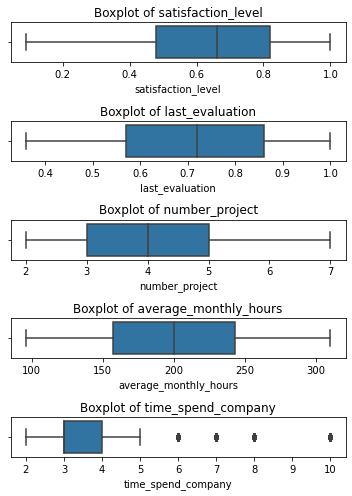

In [26]:
columns = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']
# Boxplot of all variables for checking outliers

fig, axes = plt.subplots(5,1, figsize=(5, 7))

for i, column in enumerate(columns):
    sns.boxplot(data=df1, x=column, showfliers=True, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    
plt.tight_layout()

In [27]:
greater_than_5 = df1[df1['time_spend_company'] > 5].shape[0]
print('People who were in the company for more than 5 years:', greater_than_5)
print('Percentage:', greater_than_5/df1.shape[0]*100)

People who were in the company for more than 5 years: 824
Percentage: 6.8718205320657155


<span style="color:red">**Observations:**</span>
* The only variable with outliers is `time_spend_company` and are the values over six years in the company.
* There are 824 entries equivalent to near 7 % of the employees in this data set who stayed 6 years or more. It is a significant amount of rows. However, aince a logistic model is very sensitive to outliers, I will need to remove them later.

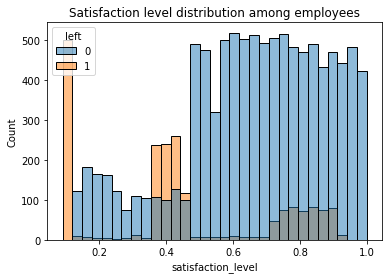

In [28]:
# Distribution of level of satisfaction among employees
sns.histplot(df1, x='satisfaction_level', hue='left')
plt.title('Satisfaction level distribution among employees');

In [29]:
print('People who left with satisfaction level below 0.5:', df1[(df1['satisfaction_level']<=0.5) & (df1['left']==1)].shape[0])
print('Percentage of left:', df1[(df1['satisfaction_level']<=0.5) & (df1['left']==1)].shape[0]/left_df.shape[0]*100)

People who left with satisfaction level below 0.5: 1414
Percentage of left: 71.01958814665997


In [30]:
print('People who left with satisfaction level below 0.15:', df1[(df1['satisfaction_level']<=0.15) & (df1['left']==1)].shape[0])
print('Percentage of left:', df1[(df1['satisfaction_level']<=0.15) & (df1['left']==1)].shape[0]/left_df.shape[0]*100)


People who left with satisfaction level below 0.15: 514
Percentage of left: 25.816172777498746


In [31]:
print('People who stayed with satisfaction level below 0.5:', df1[(df1['satisfaction_level']<=0.5) & (df1['left']==0)].shape[0])
print('Percentage of stayed:', df1[(df1['satisfaction_level']<=0.5) & (df1['left']==0)].shape[0]/no_left_df.shape[0])

People who stayed with satisfaction level below 0.5: 1970
Percentage of stayed: 0.197


In [32]:
print('People who stayed with satisfaction level below 0.15:', df1[(df1['satisfaction_level']<=0.15) & (df1['left']==0)].shape[0])
print('Percentage of stayed:', df1[(df1['satisfaction_level']<=0.15) & (df1['left']==0)].shape[0]/no_left_df.shape[0])

People who stayed with satisfaction level below 0.15: 189
Percentage of stayed: 0.0189


<span style="color:red">**Observations:**</span> Unlike actual employees, 71 % who left the company rated their satisfaction level under 0.5 and a around 26 % under 0.15.

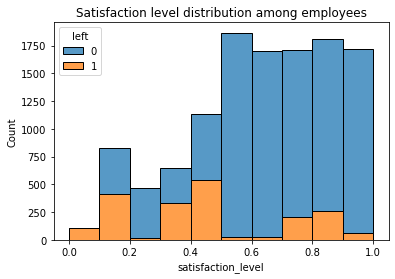

In [33]:
# Distribution of level of satisfaction among employees
sns.histplot(df1, x='satisfaction_level', hue='left', bins=10, binrange=(0,1), multiple='stack')
plt.title('Satisfaction level distribution among employees');

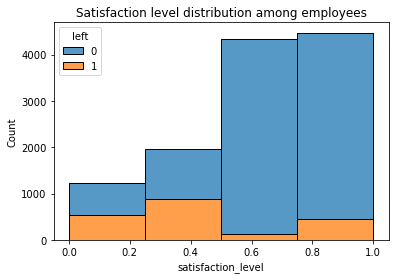

In [34]:
# Distribution of level of satisfaction among employees
sns.histplot(df1, x='satisfaction_level', hue='left', bins=4, binrange=(0,1), multiple='stack')
plt.title('Satisfaction level distribution among employees');

<span style="color:red">**Observations:**</span> Satisfaction level could be bucketised to categories: 0 to 3 (bad), more than 3 to 6 (poor), more than 6 to 8 (good), more than 8 to 10 (excellent). However, this won’t be useful for a logistic model, which needs float values.

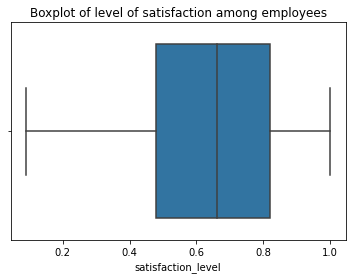

In [35]:
# Double check of outliers in level of satisfaction
sns.boxplot(data=df1, x='satisfaction_level', showfliers=True)
plt.title('Boxplot of level of satisfaction among employees');

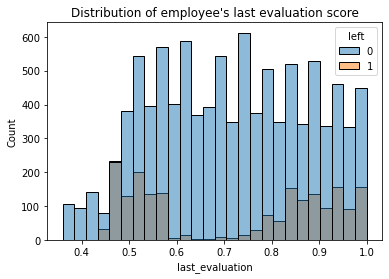

In [36]:
# Distribution of employee's last evaluation score
sns.histplot(df1, x='last_evaluation', hue='left')
plt.title("Distribution of employee's last evaluation score");

In [37]:
left_df['last_evaluation'].describe()

count    1991.000000
mean        0.721783
std         0.197436
min         0.450000
25%         0.520000
50%         0.790000
75%         0.910000
max         1.000000
Name: last_evaluation, dtype: float64

In [38]:
no_left_df['last_evaluation'].describe()

count    10000.000000
mean         0.715667
std          0.161919
min          0.360000
25%          0.580000
50%          0.710000
75%          0.850000
max          1.000000
Name: last_evaluation, dtype: float64

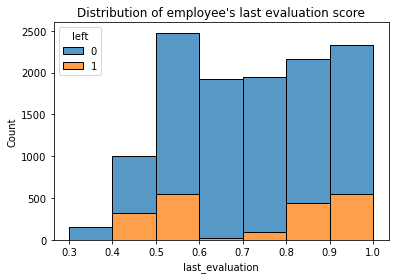

In [39]:
# Distribution of employee's last evaluation score
sns.histplot(df1, x='last_evaluation', hue='left', bins=7, binrange=(0.3,1), multiple='stack')
plt.title("Distribution of employee's last evaluation score");

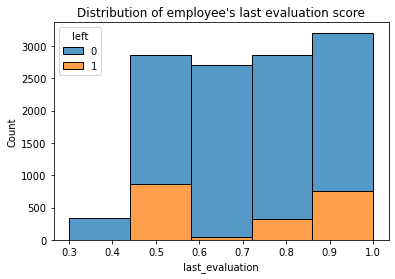

In [40]:
# Distribution of employee's last evaluation score
sns.histplot(df1, x='last_evaluation', hue='left', bins=5, binrange=(0.3,1), multiple='stack')
plt.title("Distribution of employee's last evaluation score");

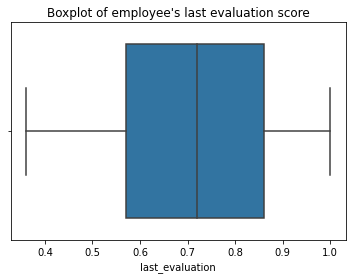

In [41]:
# Double check of employee's last evaluation score
sns.boxplot(data=df1, x='last_evaluation', showfliers=True)
plt.title("Boxplot of employee's last evaluation score");

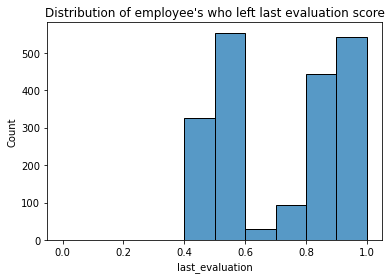

In [42]:
sns.histplot(left_df, x='last_evaluation', bins=10, binrange=(0,1))
plt.title("Distribution of employee's who left last evaluation score");

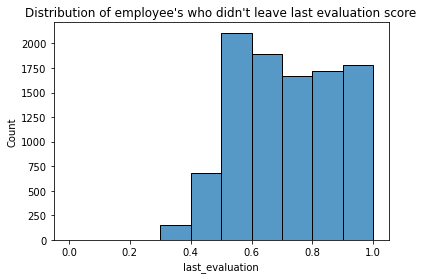

In [43]:
sns.histplot(no_left_df, x='last_evaluation', bins=10, binrange=(0,1))
plt.title("Distribution of employee's who didn't leave last evaluation score");

<span style="color:red">**Observations:**</span>
* It’s interesting that the last evaluation scores for people who left the company start higher, at 0.45, whereas for those who stayed, they start at 0.36.
* In both groups, the most common scores fall around 0.5 to 0.6.
* However, the proportion of people who left in the 0.6 to 0.8 range is very small compared to those who are still with the company.
* The proportion of people with high scores (0.9 to 1) is greater among those who left Salifort Motors.
* In conclusion, last evaluation scores will be important to predict whether an employee leaves.

In [44]:
# Table with number of employees by years working in the company
employee_years = df1[['time_spend_company', 'left']].reset_index().groupby(['time_spend_company', 'left']).count().reset_index().rename({'index' : 'Number of employees'}, axis=1)
employee_years.head()

,time_spend_company,left,Number of employees
0,2,0,2879
1,2,1,31
2,3,0,4316
3,3,1,874
4,4,0,1510


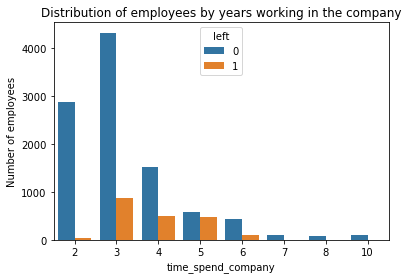

In [45]:
# Bar graph of number of employees by years working in the company
sns.barplot(data=employee_years, x='time_spend_company', y='Number of employees', hue='left')
plt.title('Distribution of employees by years working in the company');

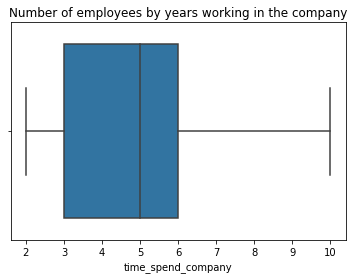

In [46]:
# Double check of number of employees by years working in the company
sns.boxplot(data=employee_years, x='time_spend_company', showfliers=True)
plt.title('Number of employees by years working in the company');

<span style="color:red">**Observations:**</span> All employees in the data set have lasted at least two years in the company and the maximum is 10. The most common time spent in the company is three years.

### Check outliers

Check for outliers in the data.

In [47]:
# Create a boxplot to visualize distribution of and detect any outliers
# ?

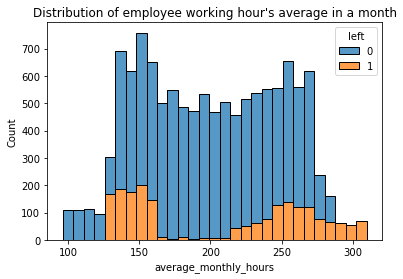

In [48]:
# Distribution of employee working hour's average in a month
sns.histplot(df1, x='average_monthly_hours', hue='left', multiple='stack')
plt.title("Distribution of employee working hour's average in a month");

<span style="color:red">**Observations:**</span> The standard number of monthly working hours in the United States is 160 (based on a 40-hour workweek). That said, the previous distribution shows critical levels of overworking among all employees, with even higher values for those who left the company. This suggests that monthly working hours will be an important variable when predicting turnover rates.

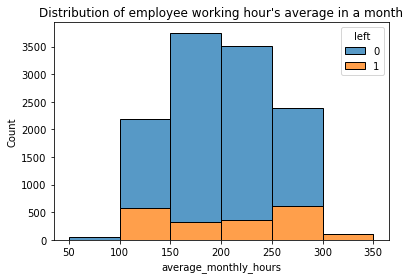

In [49]:
# Distribution of employee working hour's average in a month
sns.histplot(df1, x='average_monthly_hours', hue='left', bins=6, binrange=(50, 350) , multiple='stack')
plt.title("Distribution of employee working hour's average in a month");

In [50]:
# Maximum average monthly hours for employees who stayed at the company
max_hours_stayed = df1[df1['left'] == 0]['average_monthly_hours'].max()
max_hours_stayed

287

In [51]:
emp_extra_hours = df1[(df1['left'] == 1) & (df1['average_monthly_hours'] > max_hours_stayed)]
emp_extra_hours.shape

(184, 10)

In [52]:
100 * emp_extra_hours.shape[0] / df1[df1['left'] == 1].shape[0]

9.241587142139629

<span style="color:red">**Observations:**</span> Employees in the data set who stayed at the company have never worked more than 287 hours in average per month. Unlike 184 employees who left the company, who represent 9.24 % of the turnover.

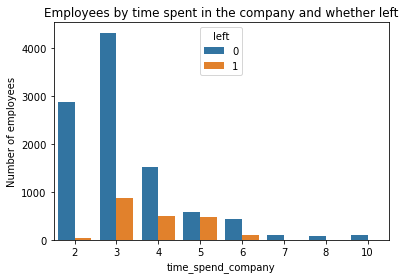

In [ ]:
# Employees by tenure who were involved and whether left
employee_time = df1[['time_spend_company', 'left']].groupby(['time_spend_company', 'left']).size().reset_index(
                                                                                    ).rename({0 : 'Number of employees'}, axis=1)

sns.barplot(data=employee_time, x='time_spend_company', y='Number of employees', hue='left')#, multiple='stack')
plt.title('Employees by time spent in the company and whether left');

In [54]:
percentage_left = df1.groupby('time_spend_company')['left'].mean()*100
percentage_left

time_spend_company
2      1.065292
3     16.840077
4     24.688279
5     45.386064
6     20.110701
7      0.000000
8      0.000000
10     0.000000
Name: left, dtype: float64

In [55]:
df1[['time_spend_company', 'left']].groupby('left').mean()

,time_spend_company
left,
0,3.262000
1,3.881467


In [56]:
print('People who stayed and greater or equal than 4 years:', df1[(df1['time_spend_company']>=4) & (df1['left']==0)].shape[0])
print('Percentage of stayed:', df1[(df1['time_spend_company']>=4) & (df1['left']==0)].shape[0]/no_left_df.shape[0])

People who stayed and greater or equal than 4 years: 2805
Percentage of stayed: 0.2805


In [57]:
print('People who left and greater or equal than 4 years:', df1[(df1['time_spend_company']>=4) & (df1['left']==1)].shape[0])
print('Percentage of stayed:', df1[(df1['time_spend_company']>=4) & (df1['left']==1)].shape[0]/left_df.shape[0])

People who left and greater or equal than 4 years: 1086
Percentage of stayed: 0.5454545454545454


<span style="color:red">**Observations:**</span>
* People who left the company stayed for a maximum of six years, with the highest percentage (45 %) leaving in their fifth year.
* However, the average time in the company is slightly higher for those who left (3.9 years) than for those who stayed (3.3 years).
* So 'time_spend_company' is going to be also a good variable for predicting turnover rates.

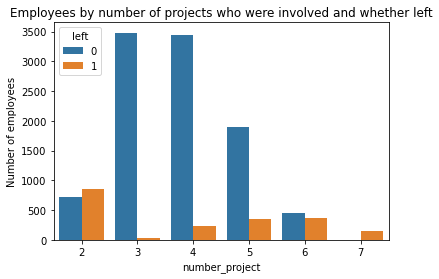

In [58]:
#### Employees by number of projects who were involved and whether left
employee_project = df1[['number_project', 'left']].groupby(['number_project', 'left']).size().reset_index(
                                                                                    ).rename({0 : 'Number of employees'}, axis=1)

sns.barplot(data=employee_project, x='number_project', y='Number of employees', hue='left')#, multiple='stack')
plt.title('Employees by number of projects who were involved and whether left');

In [59]:
left_df['number_project'].value_counts(normalize=True)

2    0.430437
6    0.186339
5    0.172275
4    0.119036
7    0.072828
3    0.019086
Name: number_project, dtype: float64

In [60]:
no_left_df['number_project'].value_counts(normalize=True)

3    0.3482
4    0.3448
5    0.1890
2    0.0725
6    0.0455
Name: number_project, dtype: float64

<span style="color:red">**Observations:**</span> Is promotion during the last 5 years a relevant variable for predicting an employee leaving the company?

In [61]:
df1['promotion_last_5years'].value_counts()

0    11788
1      203
Name: promotion_last_5years, dtype: int64

In [62]:
df1['promotion_last_5years'].value_counts(normalize=True)

0    0.983071
1    0.016929
Name: promotion_last_5years, dtype: float64

In [63]:
df1.groupby('promotion_last_5years')['left'].mean()*100

promotion_last_5years
0    16.822192
1     3.940887
Name: left, dtype: float64

<span style="color:red">**Observations:**</span>
* 17 % of employees who were not promoted in the last 5 years left the company.
* 4 % of employees who were promoted in the last 5 years left the company.

In [64]:
promotion = (
    df1.groupby(['left'])['promotion_last_5years']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Employees percentage')
    .reset_index()
)

promotion

,left,promotion_last_5years,Employees percentage
0,0,0,98.050000
1,0,1,1.950000
2,1,0,99.598192
3,1,1,0.401808


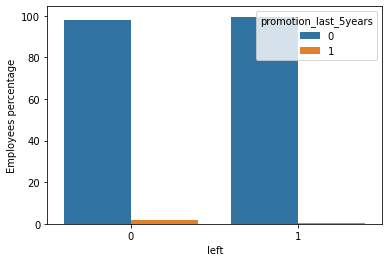

In [65]:
sns.barplot(data=promotion, x='left', y='Employees percentage', hue='promotion_last_5years')

<span style="color:red">**Observations:**</span> Promotion frequency among employees who stayed is almost 5 times the one who left. Then, Promotion during the last five years is a relevant feature to predict whether an employee leaves the company.

In [66]:
promotion2 = pd.DataFrame(df1.groupby(['department', 'left'])['promotion_last_5years'].sum().reset_index())
promotion2.head()

,department,left,promotion_last_5years
0,IT,0,0
1,IT,1,2
2,RandD,0,21
3,RandD,1,0
4,accounting,0,10


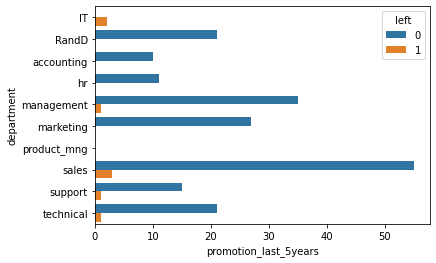

In [67]:
sns.barplot(data=promotion2, x='promotion_last_5years', y='department', hue='left')

<span style="color:red">**Observations:**</span> In general, in every department, people how was promoted has non or very low turnover rates.

In [68]:
df1['work_accident'].value_counts()

0    10141
1     1850
Name: work_accident, dtype: int64

In [69]:
# Percentage of employees who left the company depending on whether they has a work accident 
accident = df1.groupby('work_accident')['left'].mean()*100
accident

work_accident
0    18.597771
1     5.675676
Name: left, dtype: float64

<span style="color:red">**Observations:**</span> Around 15% of employees had an accident. Among them, only about 5.7% left the company, while among those who didn’t have an accident, the percentage of employees who left rises to 18.6%.

In [70]:
salary = df1.groupby('salary')['left'].mean()*100
salary

salary
low       20.452962
medium    14.616993
high       4.848485
Name: left, dtype: float64

<span style="color:red">**Observations:**</span> The lower the salary, the higher the percentage of people who left the company. We can conclude that salary is also relevant when predicting turnover rates.

Certain types of models are more sensitive to outliers than others. When you get to the stage of building your model, consider whether to remove outliers, based on the type of model you decide to use.

# Pace: Analyze Stage
- Perform EDA (analyze relationships between variables)



💭
### Reflect on these questions as you complete the analyze stage.

- What did you observe about the relationships between variables?
- What do you observe about the distributions in the data?
- What transformations did you make with your data? Why did you chose to make those decisions?
- What are some purposes of EDA before constructing a predictive model?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?




# MISSING
[Double-click to enter your responses here.]

## Step 2. Data Exploration (Continue EDA)

Begin by understanding how many employees left and what percentage of all employees this figure represents.

In [71]:
# Get numbers of people who left vs. stayed
# Done above

# Get percentages of people who left vs. stayed
# Done above

### Data visualizations

Now, examine variables that you're interested in, and create plots to visualize relationships between variables in the data.

In [72]:
# Verify number of columns after removing duplicates
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   time_spend_company     11991 non-null  int64   
 5   work_accident          11991 non-null  int64   
 6   left                   11991 non-null  int64   
 7   promotion_last_5years  11991 non-null  int64   
 8   department             11991 non-null  object  
 9   salary                 11991 non-null  category
dtypes: category(1), float64(2), int64(6), object(1)
memory usage: 855.1+ KB


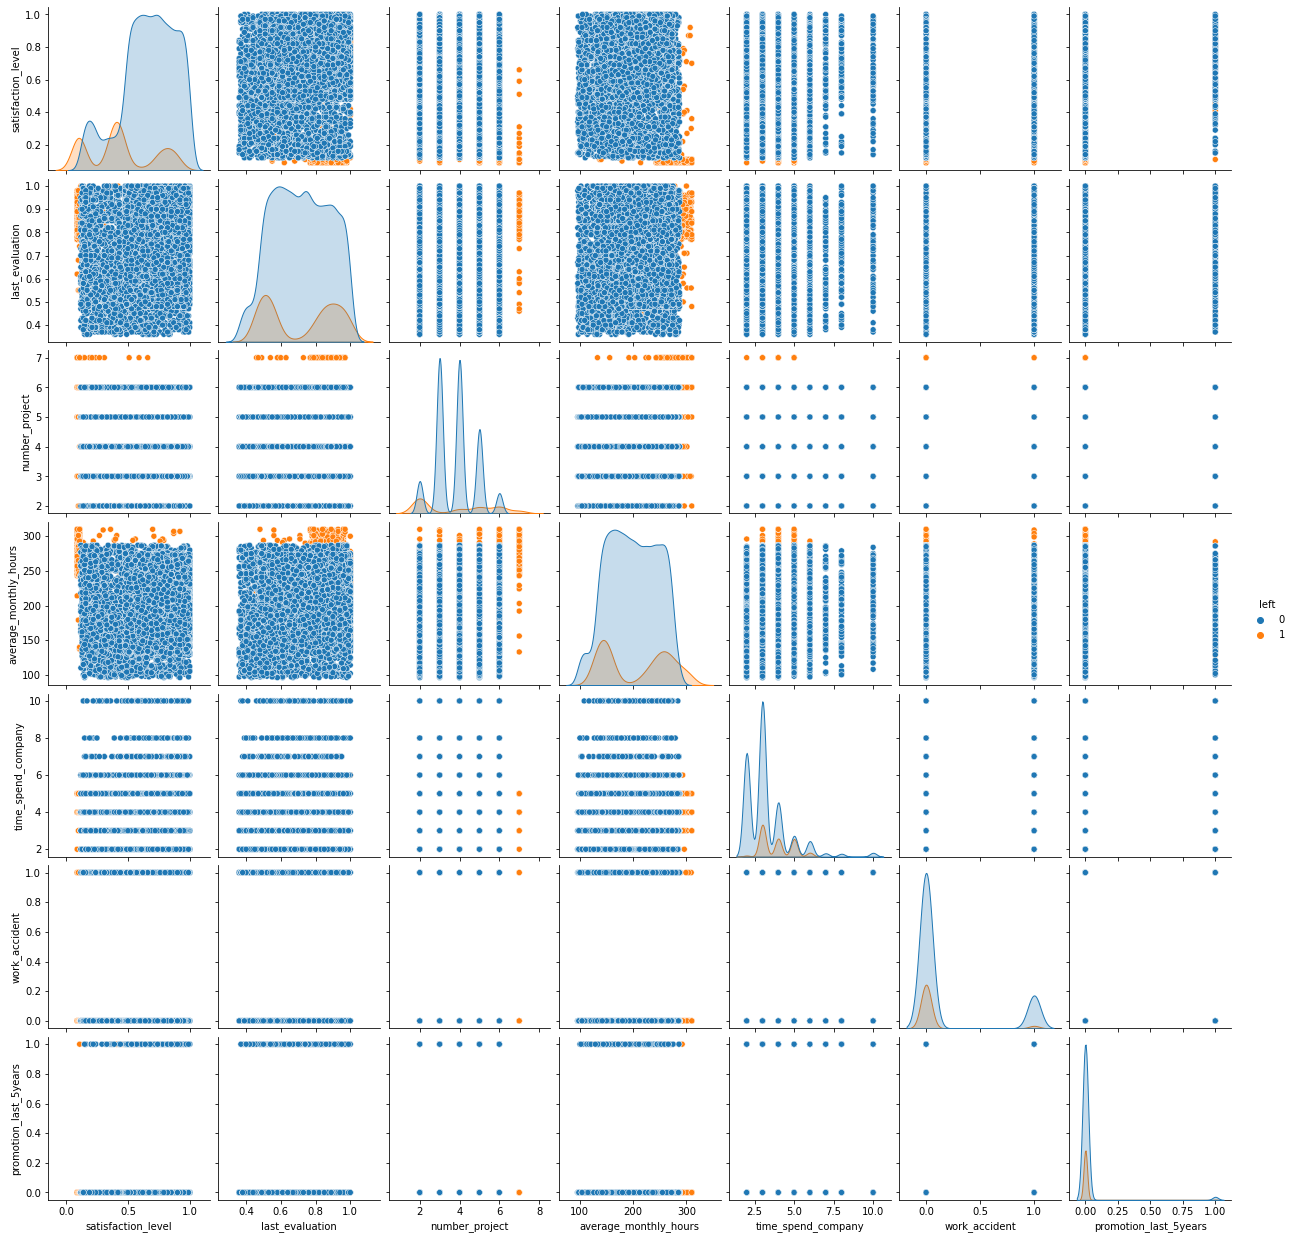

In [73]:
# Since it takes time to load, uncomment only when needed.
#sns.pairplot(df1, hue='left')

<span style="color:red">**Observations:**</span> I'm going to start the analysis with the two nominal variables, `department` and `salary`.

In [74]:
# Table with number of employees distributed by Department, salary and whether they left the company
dept_sal_left = df1[['department', 'salary', 'left']].groupby(['department', 'salary', 'left']).size()
dept_sal_left.head(10)

department  salary  left
IT          low     0       389
                    1        87
            medium  0       362
                    1        67
            high    0        67
                    1         4
RandD       low     0       271
                    1        51
            medium  0       294
                    1        31
dtype: int64

In [75]:
dept_left_percentages = dept_sal_left.groupby(level=0).apply(lambda dept: dept/dept.sum()*100)
dept_left_percentages.head(10)

department  salary  left
IT          low     0       39.856557
                    1        8.913934
            medium  0       37.090164
                    1        6.864754
            high    0        6.864754
                    1        0.409836
RandD       low     0       39.048991
                    1        7.348703
            medium  0       42.363112
                    1        4.466859
dtype: float64

In [76]:
# Table with percentage of employees distributed by Department, salary and whether they left the company
dept_left_percentages = dept_sal_left.groupby(level=0).apply(lambda dept: dept/dept.sum()*100)

dept_left_percentages = pd.DataFrame(dept_left_percentages.round(2)).reset_index().rename({0 : 'Employees percentage'}, axis=1)

dept_left_percentages.head(10)

,department,salary,left,Employees percentage
0,IT,low,0,39.86
1,IT,low,1,8.91
2,IT,medium,0,37.09
3,IT,medium,1,6.86
4,IT,high,0,6.86
5,IT,high,1,0.41
6,RandD,low,0,39.05
7,RandD,low,1,7.35
8,RandD,medium,0,42.36
9,RandD,medium,1,4.47


In [77]:
# Add a column of the contribution to the percentage of employees by department and salary range and whether left the company
dept_left_percentages['emp_per_sum'] = dept_left_percentages.groupby(['department', 'left'])['Employees percentage'].transform('sum')

dept_left_percentages['emp_per_dept'] = (100 * dept_left_percentages['Employees percentage']/ \
                                         dept_left_percentages['emp_per_sum']).round(2)

dept_left_percentages.head(10)

,department,salary,left,Employees percentage,emp_per_sum,emp_per_dept
0,IT,low,0,39.86,83.81,47.56
1,IT,low,1,8.91,16.18,55.07
2,IT,medium,0,37.09,83.81,44.25
3,IT,medium,1,6.86,16.18,42.40
4,IT,high,0,6.86,83.81,8.19
5,IT,high,1,0.41,16.18,2.53
6,RandD,low,0,39.05,87.75,44.50
7,RandD,low,1,7.35,12.25,60.00
8,RandD,medium,0,42.36,87.75,48.27
9,RandD,medium,1,4.47,12.25,36.49


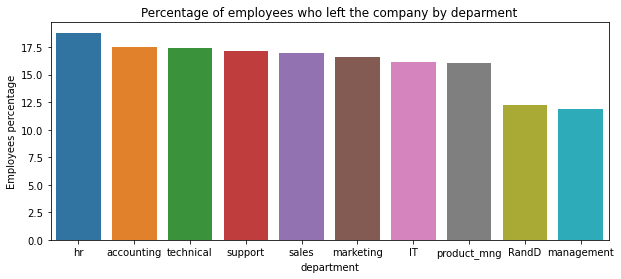

In [78]:
# Bar graph of percentages of employees who left the company by deparment
dept_left = dept_left_percentages[dept_left_percentages['left'] == 1].sort_values(by='emp_per_sum', ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(data=dept_left, x='department', y='emp_per_sum')
plt.ylabel('Employees percentage')
plt.title('Percentage of employees who left the company by deparment');

<span style="color:red">**Observations:**</span>

- The percentage of employees who left the company is different by Departments, so the latter must be a predictor variable for the model. Human Resources has the highest rate of employees who have left the company with 18.8 %, followed by Accounting with 17.6 % and Technical at 17.4 %. The lowest turnover rates are in Management, 11.9 %, and Resources and Development 12.2 %.
- From these results it can also be concluded that turnover rate is over 11 % for the whole company.

In [79]:
# Number of employees by salary range and whether they left the company
sal_left = dept_sal_left.groupby(['salary', 'left'], level=1).sum()
sal_left

salary  left
low     0       4566
        1       1174
medium  0       4492
        1        769
high    0        942
        1         48
dtype: int64

In [80]:
# Table with percentage of employees distributed by salary range and whether left the company
salary_percentages = sal_left.groupby(level=0).apply(lambda sal: sal/sal.sum()*100)
salary_percentages = pd.DataFrame(salary_percentages.round(2)).reset_index().rename({0 : 'Employees percentage'}, axis=1)
salary_percentages

,salary,left,Employees percentage
0,low,0,79.55
1,low,1,20.45
2,medium,0,85.38
3,medium,1,14.62
4,high,0,95.15
5,high,1,4.85


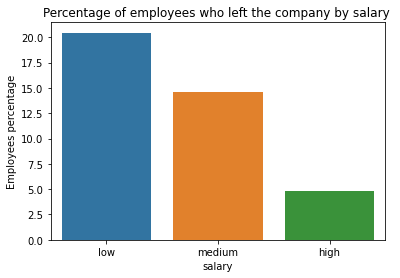

In [81]:
# Bar graph with percentage of employees who left the company distributed by salary range.
salary_left = salary_percentages[salary_percentages['left'] == 1]

sns.barplot(data=salary_left, x='salary', y='Employees percentage')
plt.title('Percentage of employees who left the company by salary ');

<span style="color:red">**Observations:**</span> Turnover rates are related to salary range. The lower the salary the higher the percentage of employees who left the company. Employees with low salaries have 20.5 % of people who have left, medium salaries 14,6 % and high salaries 4.8 %. Salary must be considered as a response variable in the model.

In [82]:
# Contribution to the percentage of employees who left the company within a department and by salary range

left_dept_sal_per = dept_left_percentages[dept_left_percentages['left'] == 1]

dept_salary_pivot = left_dept_sal_per.pivot(index='department', columns='salary', values='emp_per_dept').sort_values(
                                                                                                by='low', ascending=False)
dept_salary_pivot

salary,low,medium,high
department,,,
marketing,67.85,29.45,2.70
management,61.53,36.55,1.93
support,61.24,37.19,1.58
technical,61.01,36.40,2.59
RandD,60.00,36.49,3.51
sales,58.01,39.81,2.18
IT,55.07,42.40,2.53
hr,54.86,42.48,2.66
accounting,54.13,43.13,2.74


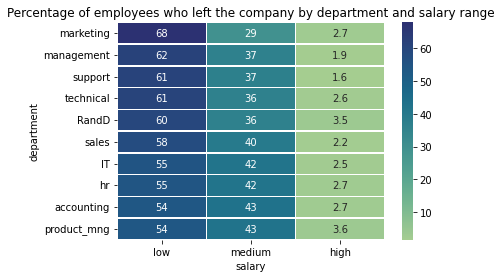

In [83]:
# Heat map of percentage of employees who left the company within a department and by salary range
sns.heatmap(dept_salary_pivot, annot=True, cmap='crest', linewidth=0.5)
plt.title('Percentage of employees who left the company by department and salary range');

<span style="color:red">**Observations:**</span> When analysing turnover percentage by salary range within all departments, low salary employees are the most likely to leave the company. For instance, low wage contributes in 68 % of turnover in Marketing department, whilst in Management represents 62 %, followed by a 61 % in Support and Technical departments.

<span style="color:red">**Observations:**</span> Now it's time to analyse the numerical variables. I'm going to start checking pearson correlation among them.

In [84]:
# Matrix of Pearson correlations among numerical variables
correlation = df1.corr()
correlation

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.095186,-0.133246,-0.006252,-0.152915,0.039940,-0.350558,0.019789
last_evaluation,0.095186,1.000000,0.270256,0.264678,0.096829,-0.005695,0.013520,-0.007206
number_project,-0.133246,0.270256,1.000000,0.331516,0.188837,-0.005612,0.030928,-0.000544
average_monthly_hours,-0.006252,0.264678,0.331516,1.000000,0.102875,-0.012860,0.070409,-0.004964
time_spend_company,-0.152915,0.096829,0.188837,0.102875,1.000000,0.000003,0.173295,0.056828
work_accident,0.039940,-0.005695,-0.005612,-0.012860,0.000003,1.000000,-0.125436,0.029852
left,-0.350558,0.013520,0.030928,0.070409,0.173295,-0.125436,1.000000,-0.044657
promotion_last_5years,0.019789,-0.007206,-0.000544,-0.004964,0.056828,0.029852,-0.044657,1.000000


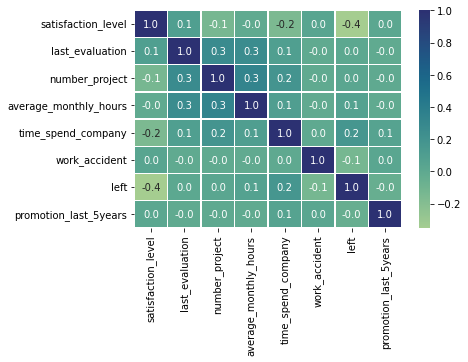

In [85]:
# Heat map of Pearson correlations among numerical variables
sns.heatmap(data=correlation, cmap='crest', annot=True, linewidth=0.5, fmt='.1f')

<span style="color:red">**Observations:**</span>
* In general, all the numerical variables have very poor correlations, which will be good for a logistic model where multicollineartity violates its assumptions.
* However the correlation with our target variable is very low as well, so I will need to transform some of those variables in order to get better relationships with it.

In [86]:
# Percentage of employees by work accident and left variables 
accident = (
    df1.groupby('work_accident')['left']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Employees percentage')
    .reset_index()
)

accident

,work_accident,left,Employees percentage
0,0,0,81.402229
1,0,1,18.597771
2,1,0,94.324324
3,1,1,5.675676


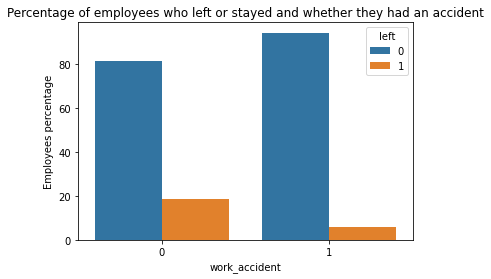

In [87]:
# Bar graph showing percentage of employees who left or stayed and whether they had an accident
sns.barplot(data=accident, x='work_accident', y='Employees percentage', hue='left')
plt.title('Percentage of employees who left or stayed and whether they had an accident');

<span style="color:red">**Observations:**</span> The percentage of employees who had an accident but stayed at the company is 18.6 %, which about three times the percentage of who had an accident and left. Having an accident doesn't increase the likelihood of leaving the company.

In [88]:
# Table with percentages of employees by work accident, department and whether they left the company
accident_dept = (
    df1.groupby(['department', 'left'])['work_accident']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Employees percentage')
    .reset_index()
)

accident_dept.head()

,department,left,work_accident,Employees percentage
0,IT,0,0,83.863081
1,IT,0,1,16.136919
2,IT,1,0,95.569620
3,IT,1,1,4.430380
4,RandD,0,0,81.609195


<span style="color:red">**Observations:**</span> Is there any relation between work accidents, the department the employee belong to and whether they left the company?

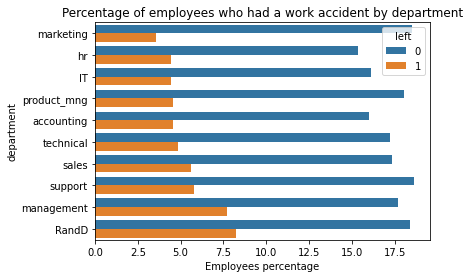

In [89]:
# Bar graph of percentage of employees who had a work accident by department
sns.barplot(data=accident_dept[accident_dept['work_accident'] == 1].sort_values(by='Employees percentage', ascending=True),
            x='Employees percentage', y='department', hue='left')

plt.title('Percentage of employees who had a work accident by department');

In [90]:
# Table with percentages of employees by work accident and department
accident_dept2 = (
    df1.groupby(['department'])['work_accident']
    .value_counts(normalize=True)
    .mul(100)
    .rename('Employees percentage')
    .reset_index()
)

accident_dept2.head()

,department,work_accident,Employees percentage
0,IT,0,85.758197
1,IT,1,14.241803
2,RandD,0,82.853026
3,RandD,1,17.146974
4,accounting,0,85.990338


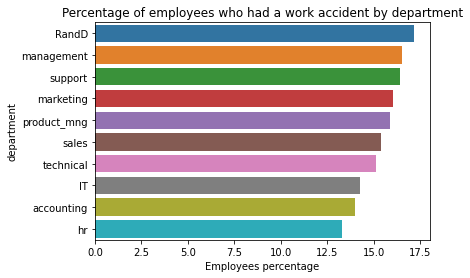

In [91]:
# Bar graph with percentage of employees who had a work accident by department
sns.barplot(data=accident_dept2[accident_dept2['work_accident'] == 1].sort_values(by='Employees percentage', ascending=False),
            x='Employees percentage', y='department')

plt.title('Percentage of employees who had a work accident by department');

<span style="color:red">**Observations:**</span> There is no clear relationship between work accidents, the department an employee belong and whether they left the company. We could still make a hypothesis test to double check work accidents is not a relevant variable for leaving this company.

<span style="color:red">**Observations:**</span> In the next analysis I'm going to study relations among number of projects, salary range, time spent in the company and whether the employee left the company.

In [92]:
# Number of employees by number of projects, salary range and whether they left
temp_df = df1[['number_project', 'salary', 'left']].groupby(['number_project', 'salary', 'left']).size().reset_index(
                                                                                    ).rename({0 : 'Number of employees'}, axis=1)
temp_df.head()

,number_project,salary,left,Number of employees
0,2,low,0,342
1,2,low,1,512
2,2,medium,0,308
3,2,medium,1,322
4,2,high,0,75


In [93]:
# Pivot table with number of employees by number of projects, salary range and whether they left
project_salary_left = temp_df[temp_df['left'] == 1].pivot(index='number_project', columns='salary', values='Number of employees')
project_salary_left

salary,low,medium,high
number_project,,,
2,512,322,23
3,21,16,1
4,140,95,2
5,198,134,11
6,221,141,9
7,82,61,2


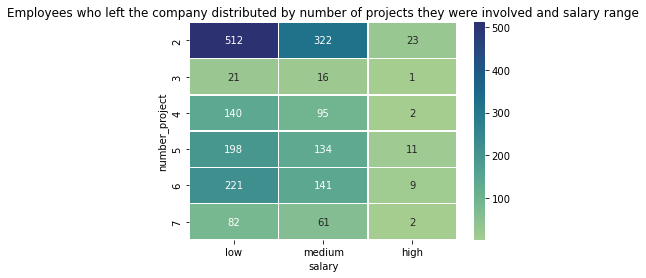

In [94]:
# Heat map of employees who left the company distributed by number of projects they were involved and salary range
sns.heatmap(data=project_salary_left, cmap='crest', annot=True, linewidth=0.5, fmt='.3g')
plt.title('Employees who left the company distributed by number of projects they were involved and salary range');

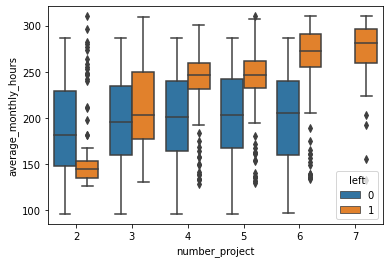

In [95]:
sns.boxplot(data=df1, x='number_project', y='average_monthly_hours', hue='left')

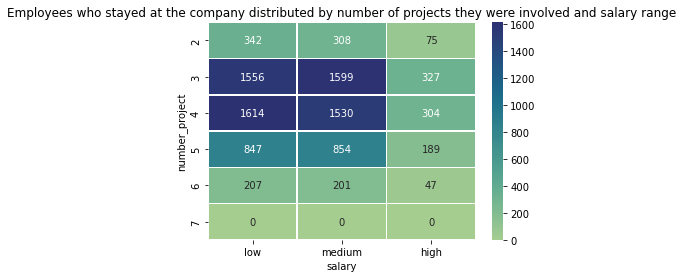

In [96]:
# Heat map of employees who stayed at the company distributed by number of projects they were involved and salary range
project_salary_stayed = temp_df[temp_df['left'] == 0].pivot(index='number_project', columns='salary', values='Number of employees')

sns.heatmap(data=project_salary_stayed, cmap='crest', annot=True, linewidth=0.5, fmt='.4g')
plt.title('Employees who stayed at the company distributed by number of projects they were involved and salary range');

<span style="color:red">**Observations:**</span> From the previous two heat maps, employees who left the company are mainly from low and medium salaries and had assigned only two projects. This contrasts with employees who stayed, since most of them participated in three and four projects. In order to understand the reasons for it, I'm going to compare them with time spent in the company.

In [97]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [98]:
# Create a plot as needed
### YOUR CODE HERE ###
time_satisfaction = df1[['satisfaction_level', 'time_spend_company', 'left']].groupby(['left', 'time_spend_company']).size()
time_satisfaction

left  time_spend_company
0     2                     2879
      3                     4316
      4                     1510
      5                      580
      6                      433
      7                       94
      8                       81
      10                     107
1     2                       31
      3                      874
      4                      495
      5                      482
      6                      109
dtype: int64

In [99]:
# Create a plot as needed
### YOUR CODE HERE ###
temp_df = df1.copy()
temp_df['average_daily_hours'] = (temp_df['average_monthly_hours'] / 30).round(2)
temp_df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary,average_daily_hours
0,0.38,0.53,2,157,3,0,1,0,sales,low,5.23
1,0.80,0.86,5,262,6,0,1,0,sales,medium,8.73
2,0.11,0.88,7,272,4,0,1,0,sales,medium,9.07
3,0.72,0.87,5,223,5,0,1,0,sales,low,7.43
4,0.37,0.52,2,159,3,0,1,0,sales,low,5.30


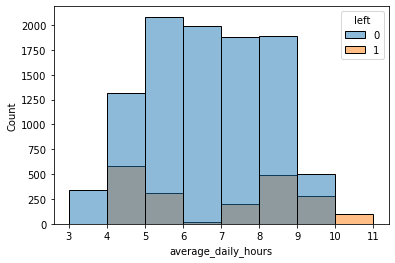

In [100]:
sns.histplot(data=temp_df, x='average_daily_hours', hue='left', bins=8, binrange=(3,11))

<span style="color:red">**Observations:**</span> As we examined earlier, employees who left the company had very long daily work periods—especially when compared to the standard 8-hour workday in the United States. The difference is also clear when compared to employees who stayed, as only a small percentage of them exceeded those values.

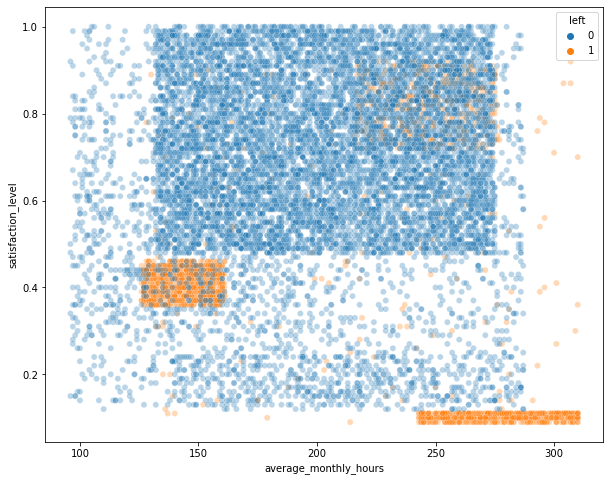

In [101]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.3)

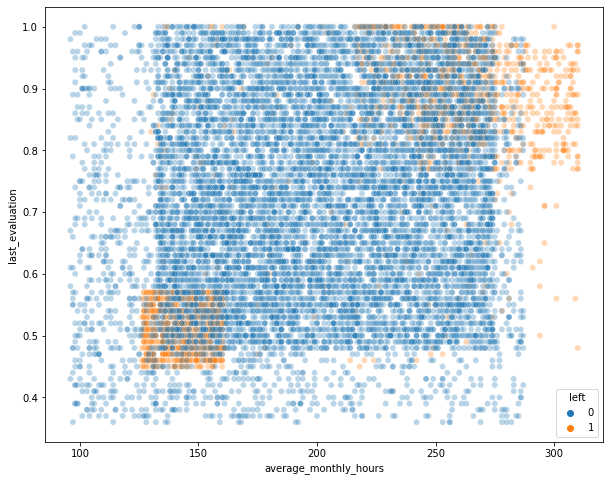

In [102]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.3)

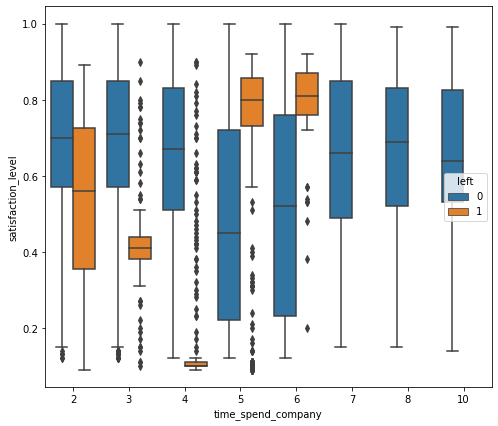

In [103]:
plt.figure(figsize=(8,7))
sns.boxplot(data=df1, x='time_spend_company', y='satisfaction_level', hue='left')

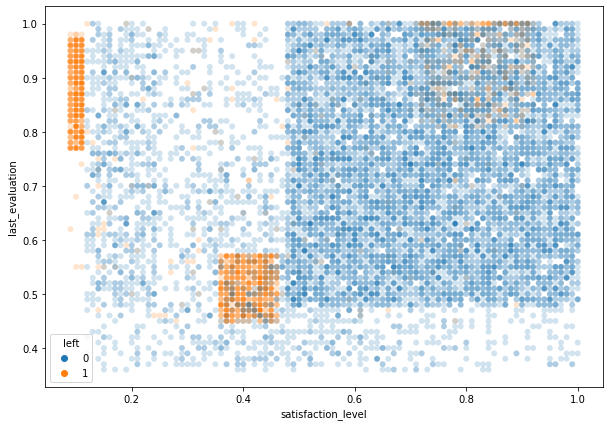

In [104]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=df1, x='satisfaction_level', y='last_evaluation', hue='left', alpha=0.2)

In [105]:
left_high_satisfaction = df1[(df1['satisfaction_level'] >= 0.7) & (df1['last_evaluation'] >= 0.8) & 
                             (df1['average_monthly_hours'] >= 210) & df1['left']==1]

In [106]:
left_high_satisfaction.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0,492.000000,492,492
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138,288
mean,0.819065,0.923130,4.575203,247.611789,5.168699,0.054878,1.0,0.002033,NaN,NaN
std,0.058417,0.059355,0.556790,17.679130,0.504558,0.227974,0.0,0.045083,NaN,NaN
min,0.700000,0.810000,2.000000,211.000000,2.000000,0.000000,1.0,0.000000,NaN,NaN
25%,0.770000,0.870000,4.000000,234.000000,5.000000,0.000000,1.0,0.000000,NaN,NaN
50%,0.820000,0.930000,5.000000,247.000000,5.000000,0.000000,1.0,0.000000,NaN,NaN
75%,0.870000,0.980000,5.000000,261.000000,5.000000,0.000000,1.0,0.000000,NaN,NaN


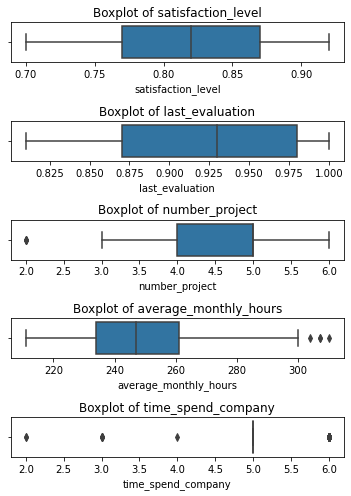

In [107]:
columns = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']
# Boxplot of all variables for checking outliers

fig, axes = plt.subplots(5,1, figsize=(5, 7))

for i, column in enumerate(columns):
    sns.boxplot(data=left_high_satisfaction, x=column, showfliers=True, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    
plt.tight_layout()

In [108]:
left_high_satisfaction.shape[0]

492

In [109]:
left_high_satisfaction[left_high_satisfaction['time_spend_company']==5].shape[0]/left_high_satisfaction.shape[0]*100

78.04878048780488

In [110]:
time_promotion = (df1.groupby(['time_spend_company','left'])['promotion_last_5years'].mean()*100).reset_index()
time_promotion

,time_spend_company,left,promotion_last_5years
0,2,0,1.354637
1,2,1,0.000000
2,3,0,1.923077
3,3,1,0.686499
4,4,0,1.390728
5,4,1,0.202020
6,5,0,1.724138
7,5,1,0.207469
8,6,0,2.540416
9,6,1,0.000000


In [111]:
time_promotion = time_promotion.drop([10, 11, 12], axis=0)

In [112]:
left_high_satisfaction['promotion_last_5years'].value_counts()

0    491
1      1
Name: promotion_last_5years, dtype: int64

Text(0, 0.5, 'Percentage of promoted employees')

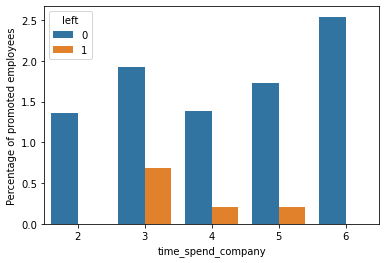

In [113]:
sns.barplot(data=time_promotion, x='time_spend_company', y='promotion_last_5years', hue='left')
plt.ylabel('Percentage of promoted employees')

In [114]:
time_salary_promotion = (df1.groupby(['time_spend_company', 'salary'])['promotion_last_5years'].mean()*100).reset_index()
time_salary_promotion.head()

,time_spend_company,salary,promotion_last_5years
0,2,low,0.363901
1,2,medium,2.112676
2,2,high,2.713178
3,3,low,0.714569
4,3,medium,2.397869


In [115]:
left_high_satisfaction['salary'].value_counts(normalize=True)

low       0.585366
medium    0.394309
high      0.020325
Name: salary, dtype: float64

Text(0, 0.5, 'Percentage of promoted employees')

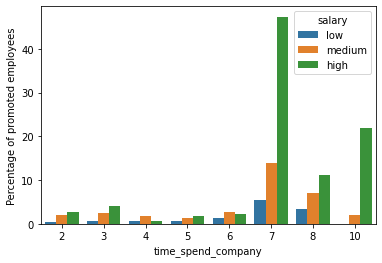

In [116]:
sns.barplot(data=time_salary_promotion, x='time_spend_company', y='promotion_last_5years', hue='salary')
plt.ylabel('Percentage of promoted employees')

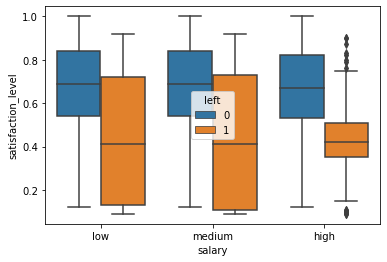

In [117]:
sns.boxplot(data=df1, x='salary', y='satisfaction_level', hue='left')

### Creation of new variables from the original ones

<span style="color:red">**Observations:**</span> I consider that `average_monthly_hours` and `time_spend_company` are more menaningful if we change them

In [118]:
# Create a plot as needed
### YOUR CODE HERE ###
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [119]:
# Create a new feature: Projects by year
df1['projects_by_year'] = (df1['number_project']/df1['time_spend_company']).round(1)

In [120]:
# Create a new feature: working hours per week (which is the most standarised unit)
df1['average_weekly_hours'] = (df1['average_monthly_hours']/4).round(1)

In [121]:
print('People who stayed and less or equal than 1 projects by year:', df1[(df1['projects_by_year']<=1) & (df1['left']==0)].shape[0])
print('Percentage of stayed:', df1[(df1['projects_by_year']<=1) & (df1['left']==0)].shape[0]/no_left_df.shape[0])

People who stayed and less or equal than 1 projects by year: 4316
Percentage of stayed: 0.4316


In [122]:
print('People who left and less or equal than 1 projects by year:', df1[(df1['projects_by_year']<=1) & (df1['left']==1)].shape[0])
print('Percentage of left:', df1[(df1['projects_by_year']<=1) & (df1['left']==1)].shape[0]/left_df.shape[0])

People who left and less or equal than 1 projects by year: 1405
Percentage of left: 0.7056755399296836


In [123]:
df1.groupby('left')['projects_by_year'].mean()

left
0    1.304150
1    1.001155
Name: projects_by_year, dtype: float64

<span style="color:red">**Observations:**</span> 71% of the people who left were involved in one or no projects, compared to only 43% of those who stayed. On average, the latter worked on 1.3 projects, while the former worked on 1.0. Consequently, projects by year could be a relevant and new variable to introduce in order to predict leaving the company likelihood.

### Insights

[What insights can you gather from the plots you created to visualize the data? Double-click to enter your responses here.]

# Pace: Construct Stage
- Determine which models are most appropriate
- Construct the model
- Confirm model assumptions
- Evaluate model results to determine how well your model fits the data


🔎
## Recall model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size





💭
### Reflect on these questions as you complete the constructing stage.

- Do you notice anything odd?
- Which independent variables did you choose for the model and why?
- Are each of the assumptions met?
- How well does your model fit the data?
- Can you improve it? Is there anything you would change about the model?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



[Double-click to enter your responses here.]

In [124]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   time_spend_company     11991 non-null  int64   
 5   work_accident          11991 non-null  int64   
 6   left                   11991 non-null  int64   
 7   promotion_last_5years  11991 non-null  int64   
 8   department             11991 non-null  object  
 9   salary                 11991 non-null  category
 10  projects_by_year       11991 non-null  float64 
 11  average_weekly_hours   11991 non-null  float64 
dtypes: category(1), float64(4), int64(6), object(1)
memory usage: 1.0+ MB


In [125]:
df1 = df1.drop(['number_project', 'average_monthly_hours'], axis=1)

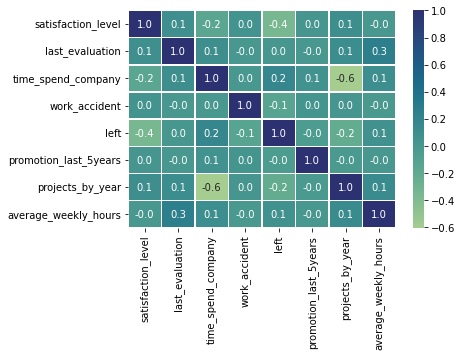

In [126]:
sns.heatmap(data=df1.corr(), cmap='crest', annot=True, linewidth=0.5, fmt='.1f')

In [128]:
df2 = df1.copy()

In [129]:
df2 = pd.get_dummies(df2, columns=['department'])

In [130]:
# Define encoder
encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])

# Check encoder classes
df2['salary'] = encoder.fit_transform(df2[['salary']])

In [131]:
# Look for multicollinearity in the independent variables
indep_var = df2.drop('left', axis=1)

In [132]:
# Create list of variance inflation factor independent variables
vif = [variance_inflation_factor(indep_var.values, i) for i in range(indep_var.shape[1])]

In [133]:
# Create a data frame of variance inflation factors
vif_df = pd.DataFrame(vif, index=indep_var.columns, columns=['VIF'])

In [134]:
# Show a data frame with VIF values
vif_df

,VIF
satisfaction_level,1.042230
last_evaluation,1.126058
time_spend_company,1.773349
work_accident,1.003897
promotion_last_5years,1.025441
salary,1.022574
projects_by_year,1.740907
average_weekly_hours,1.132963
department_IT,5.336295
department_RandD,4.071625


<span style="color:red">**Observations:**</span> 
* The only variables with a VIF greater than 5 are the departments of Sales, Support, Technical, and IT (the latter being just slightly above 5). This indicates a high level of multicollinearity. The former three departments show very similar patterns when plotted and when analyzed alongside other variables like promotion, work accident, department size, salary, etc. I’m going to remove the Sales department, which has the highest VIF, and I'm going to check VIF values. If the problem is solved, Sales department will serve as the reference or "base value" for the remaining departments.
* The other variables have very low VIF values, indicating no multicollinearity. 

<span style="color:red">**Observations:**</span>
* I tried removing different departments, but that caused other important variables to have higher VIFs. So I prefer to keep all the departments for now and test the model as is. Depending on the results, I might consider removing some of them later.
* It's time to remove the outliers for `time_spend_company`

In [135]:
final_df = df2.copy()

In [161]:
df2 = df2[df2['time_spend_company'] <= 5]

## Step 3. Model Building, Step 4. Results and Evaluation
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

### Identify the type of prediction task.

[Double-click to enter your responses here.]

### Identify the types of models most appropriate for this task.

[Double-click to enter your responses here.]

### Modeling

Add as many cells as you need to conduct the modeling process.

In [134]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11167 entries, 0 to 11990
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      11167 non-null  float64
 1   last_evaluation         11167 non-null  float64
 2   time_spend_company      11167 non-null  int64  
 3   work_accident           11167 non-null  int64  
 4   left                    11167 non-null  int64  
 5   promotion_last_5years   11167 non-null  int64  
 6   salary                  11167 non-null  float64
 7   projects_by_year        11167 non-null  float64
 8   average_weekly_hours    11167 non-null  float64
 9   department_IT           11167 non-null  uint8  
 10  department_RandD        11167 non-null  uint8  
 11  department_accounting   11167 non-null  uint8  
 12  department_hr           11167 non-null  uint8  
 13  department_management   11167 non-null  uint8  
 14  department_marketing    11167 non-null

In [135]:
df2.head()

,satisfaction_level,last_evaluation,time_spend_company,work_accident,left,promotion_last_5years,salary,projects_by_year,average_weekly_hours,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,3,0,1,0,0.0,0.7,39.2,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,4,0,1,0,1.0,1.8,68.0,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,0,1,0,0.0,1.0,55.8,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,3,0,1,0,0.0,0.7,39.8,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,3,0,1,0,0.0,0.7,38.2,0,0,0,0,0,0,0,1,0,0


### Logistic model

In [136]:
continuous_variables = df2[['satisfaction_level', 'last_evaluation', 'time_spend_company', 'salary', 'projects_by_year', 'average_weekly_hours']]

In [137]:
# Change target variable type to float, since regplot needs it that way
df2 = df2.astype({'left': float})

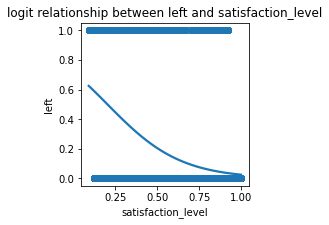

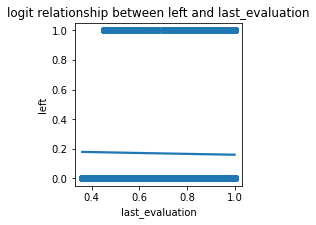

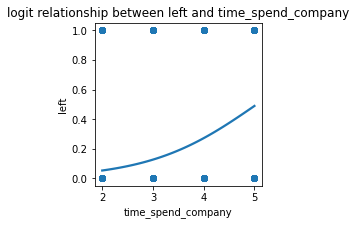

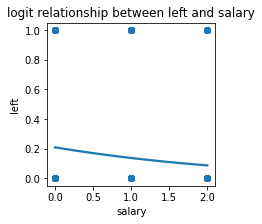

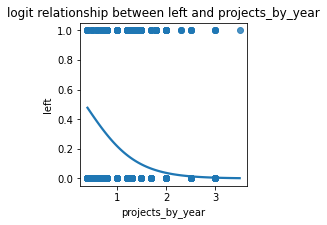

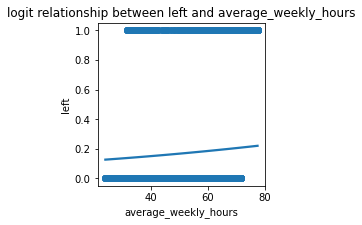

In [138]:
for continuous in continuous_variables:
    plt.figure(figsize=(3,3))
    sns.regplot(data=df2, x=continuous, y='left', logistic=True, ci=None)
    plt.title(f'logit relationship between left and {continuous}')
    plt.show()

<span style="color:red">**Observations:**</span>
* The only plot that shows an S-shaped relationship between the target variable left and an independent variable is with time_spend_company. So, the linear relationship with the logit function isn’t very clear. Still, let’s start building the model and evaluate it to get clearer results.
* Our top priority is identifying true positives and avoiding false negatives as much as possible, since the goal is to detect every person who might leave in order to take preventive actions. With that in mind, the chosen evaluation metric for our models is recall.
* That said, we’ll still check the other metrics to ensure a well-rounded evaluation of the model.

In [162]:
# Define predictor and target variables
X = df2.drop('left', axis=1)
y = df2['left']

In [163]:
# Split data frame in train, validation and test sets.
X_train, X_tst, y_train, y_tst = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_tst, y_tst, test_size=0.5, random_state=1)

In [164]:
# Verify shapes of the two splits
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7816, 18), (7816,), (1675, 18), (1675,), (1676, 18), (1676,))

In [165]:
# Standarise values in the dataframe
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

X_test_scaled = scaler.transform(X_test)

In [166]:
X_train.head()

,satisfaction_level,last_evaluation,time_spend_company,work_accident,promotion_last_5years,salary,projects_by_year,average_weekly_hours,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
8345,0.50,0.70,3,0,0,0.0,1.0,39.8,0,0,0,1,0,0,0,0,0,0
1881,0.85,0.87,5,0,0,0.0,1.0,61.2,0,0,0,0,0,0,0,0,0,1
2539,0.69,0.50,4,0,0,0.0,0.8,52.0,0,0,0,1,0,0,0,0,0,0
10484,0.66,0.94,2,1,0,0.0,2.0,44.0,0,0,0,0,0,0,0,0,0,1
8596,0.48,0.43,3,0,0,0.0,1.0,24.0,0,0,0,0,0,0,0,0,1,0


In [167]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.552632,-0.085709,-0.128306,-0.425466,-0.122201,-0.933694,-0.608561,-0.847170,-0.297113,-0.247458,-0.231325,4.300148,-0.180268,-0.243356,-0.245999,-0.602576,-0.431532,-0.486326
1,0.905011,0.931289,2.097756,-0.425466,-0.122201,-0.933694,-0.608561,0.915632,-0.297113,-0.247458,-0.231325,-0.232550,-0.180268,-0.243356,-0.245999,-0.602576,-0.431532,2.056233
2,0.238660,-1.282178,0.984725,-0.425466,-0.122201,-0.933694,-1.018906,0.157792,-0.297113,-0.247458,-0.231325,4.300148,-0.180268,-0.243356,-0.245999,-0.602576,-0.431532,-0.486326
3,0.113719,1.350053,-1.241337,2.350363,-0.122201,-0.933694,1.443164,-0.501200,-0.297113,-0.247458,-0.231325,-0.232550,-0.180268,-0.243356,-0.245999,-0.602576,-0.431532,2.056233
4,-0.635926,-1.700942,-0.128306,-0.425466,-0.122201,-0.933694,-0.608561,-2.148679,-0.297113,-0.247458,-0.231325,-0.232550,-0.180268,-0.243356,-0.245999,-0.602576,2.317328,-0.486326


In [168]:
# Instatiate and fit the model. I use class_weight
clf = LogisticRegression(class_weight='balanced', random_state=0)

clf.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [169]:
# Save predictions with validation set
y_val_pred = clf.predict(X_val_scaled)

In [170]:
y_val_proba = clf.predict_proba(X_val_scaled)[::,-1]
y_val_proba

array([0.02205565, 0.97758012, 0.13734445, ..., 0.00642251, 0.05316113,
       0.02301581])

In [148]:
cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)

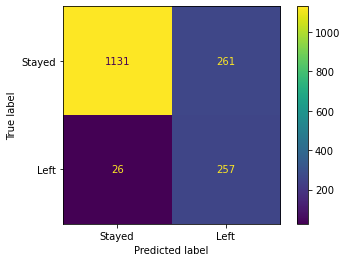

In [149]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Left'])
disp.plot(values_format='d')

In [175]:
logistic_results = model_evaluator('Logistic (scaled)', y_val, y_val_pred, y_val_proba)
logistic_results

,Model,Recall,Auc,F1,Precision,Accuracy
0,Logistic scaled,0.908127,0.896981,0.641698,0.496139,0.828657


In [153]:
print(classification_report(y_val, y_val_pred, labels=[0,1], target_names=['Stayed', 'Left']) )

              precision    recall  f1-score   support

      Stayed       0.98      0.81      0.89      1392
        Left       0.50      0.91      0.64       283

    accuracy                           0.83      1675
   macro avg       0.74      0.86      0.76      1675
weighted avg       0.90      0.83      0.85      1675



In [154]:
# Create a second logistic model to interpret its coefficients
clf_interpret = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)
clf_interpret.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
# Predict values with the validation set
y_val_pred_iprt = clf_interpret.predict(X_val)

In [156]:
# Prediction of probalities
y_val_proba_iprt = clf_interpret.predict_proba(X_val)[::,-1]

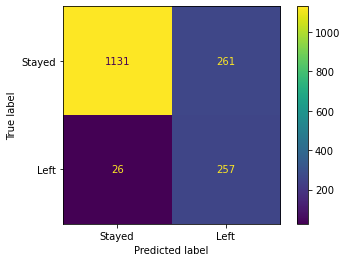

In [157]:
cm_iprt = confusion_matrix(y_val, y_val_pred_iprt, labels=clf_interpret.classes_)
disp_iprt = ConfusionMatrixDisplay(confusion_matrix=cm_iprt, display_labels=['Stayed', 'Left'])
disp_iprt.plot(values_format='d')

In [158]:
model_evaluator(y_val, y_val_pred_iprt, y_val_proba_iprt)

Recall: 0.9081272084805654
Precision: 0.49613899613899615
F1: 0.6416978776529338
Accuracy: 0.8286567164179105
ROC AUC: 0.896927419682385


In [159]:
print(classification_report(y_val, y_val_pred_iprt, labels=[0,1], target_names=['Stayed', 'Left']) )

              precision    recall  f1-score   support

      Stayed       0.98      0.81      0.89      1392
        Left       0.50      0.91      0.64       283

    accuracy                           0.83      1675
   macro avg       0.74      0.86      0.76      1675
weighted avg       0.90      0.83      0.85      1675



In [160]:
model_coefficients = pd.DataFrame({'Feature name': X.columns, 'Log odd': clf_interpret.coef_.ravel()})

In [161]:
model_coefficients['Coefficient'] = model_coefficients['Log odd'].apply(lambda log_odd: np.exp(log_odd))

In [162]:
model_coefficients['Odd of Left (percentage)'] = model_coefficients['Coefficient'].apply(
                                                                            lambda coefficient: '%.2f' % ((coefficient-1)*100)
                                                                            )

In [163]:
model_coefficients

,Feature name,Log odd,Coefficient,Odd of Left (percentage)
0,satisfaction_level,-5.308633,0.004949,-99.51
1,last_evaluation,0.416276,1.516304,51.63
2,time_spend_company,0.867157,2.380135,138.01
3,work_accident,-1.335098,0.263132,-73.69
4,promotion_last_5years,-0.632195,0.531424,-46.86
5,salary,-0.462256,0.629861,-37.01
6,projects_by_year,-2.408544,0.089946,-91.01
7,average_weekly_hours,0.013232,1.013320,1.33
8,department_IT,0.226176,1.253796,25.38
9,department_RandD,-0.083049,0.920306,-7.97


In [164]:
X_with_const = sm.add_constant(X)

In [165]:
logit_model = sm.Logit(y, X_with_const)

In [166]:
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.308918
         Iterations 9


In [167]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                   left   No. Observations:                11167
Model:                          Logit   Df Residuals:                    11149
Method:                           MLE   Df Model:                           17
Date:                Sat, 19 Apr 2025   Pseudo R-squ.:                  0.3189
Time:                        19:07:38   Log-Likelihood:                -3449.7
converged:                       True   LL-Null:                       -5064.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.9432   2.27e+06   4.15e-07      1.000   -4.45e+06    4.45e+06
satisfaction_level        -4.5673      0.136    -33.614      0.000      -4.834      -4.301
last

### Random Forest model

In [141]:
# Define predictor and target variables
X = final_df.drop('left', axis=1)
y = final_df['left']

In [142]:
# Split data frame in train, validation and test sets.
X_train, X_tst, y_train, y_tst = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_tst, y_tst, test_size=0.5, random_state=1)

In [186]:
# Create and fit a Random Forest model
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [None],
             'max_features': [8, 12, 18],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [4, 5, 6],
             'n_estimators': [75, 100, 125]
            }

scoring = {
    'recall': 'recall', 
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision', 
    'accuracy': 'accuracy'
}

rf_cv = GridSearchCV(rf,
                    cv_params,
                    scoring=scoring,
                    cv=5,
                    refit='recall'
                    )

In [187]:
%%time

rf_cv.fit(X_train, y_train)

CPU times: user 5min 38s, sys: 448 ms, total: 5min 38s
Wall time: 5min 38s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [188]:
rf_results = model_results('Random Forest', rf_cv)[0]
rf_results

,Model,Recall,Auc,F1,Precision,Accuracy
0,Random Forest,0.915742,0.974462,0.951062,0.989372,0.984136


In [189]:
(model_results('Random Forest', rf_cv)[1]).to_csv('rf_cv_df.csv')

In [190]:
rf_cv_df = pd.read_csv('rf_cv_df.csv')

In [191]:
#Use pickle:
# Define a path to the folder where you want to save the model
path = '/home/jovyan/work/'

In [192]:
# Pickle the model
with open(path + 'rf_cv_model.pickle', 'wb') as to_write:
    pkl.dump(rf_cv, to_write)

In [193]:
# Read in pickled model
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pkl.load(to_read)

In [194]:
# Examine best parameters
### YOUR CODE HERE ###
rf_cv.best_params_

{'max_depth': None,
 'max_features': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 75}

In [195]:
rf_cv.best_score_

0.9157420209701579

In [204]:
y_val_pred_rf = rf_cv.predict(X_val)

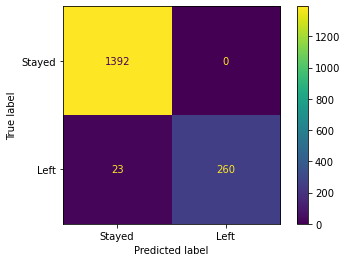

In [207]:
# Compute values for confusion matrix
cm_rf = confusion_matrix(y_val, y_val_pred_rf, labels=rf_cv.classes_)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp_cm_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Stayed', 'Left'])

# Plot confusion matrix
disp_cm_rf.plot(values_format='d')

In [196]:
# Access the GridSearch results and convert it to a pandas df
### YOUR CODE HERE ###
cv_results_table = pd.DataFrame(rf_cv.cv_results_)

In [222]:
final_table = pd.concat([logistic_results, rf_results]).sort_values(by='Recall', ascending=False)
final_table

,Model,Recall,Auc,F1,Precision,Accuracy
0,Random Forest,0.915742,0.974462,0.951062,0.989372,0.984136
0,Logistic scaled,0.908127,0.896981,0.641698,0.496139,0.828657


# pacE: Execute Stage
- Interpret model performance and results
- Share actionable steps with stakeholders



✏
## Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.






💭
### Reflect on these questions as you complete the executing stage.

- What key insights emerged from your model(s)?
- What business recommendations do you propose based on the models built?
- What potential recommendations would you make to your manager/company?
- Do you think your model could be improved? Why or why not? How?
- Given what you know about the data and the models you were using, what other questions could you address for the team?
- What resources do you find yourself using as you complete this stage? (Make sure to include the links.)
- Do you have any ethical considerations in this stage?



Double-click to enter your responses here.

## Step 4. Results and Evaluation
- Interpret model
- Evaluate model performance using metrics
- Prepare results, visualizations, and actionable steps to share with stakeholders




In [213]:
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])
X_final.shape, y_final.shape

((9491, 18), (9491,))

In [214]:
# Instatiate the winner model for classification: Random Forest
best_model = RandomForestClassifier(max_depth=None, max_features=12, min_samples_leaf=1, min_samples_split=4,
                                                 n_estimators=75, random_state=0)

In [215]:
# fit the winner model
best_model.fit(X_final, y_final)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=12,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [216]:
y_pred_best = best_model.predict(X_test)

In [219]:
y_proba_best = best_model.predict_proba(X_test)[::,-1]

Text(0.5, 1.0, 'Best model: Random Forest')

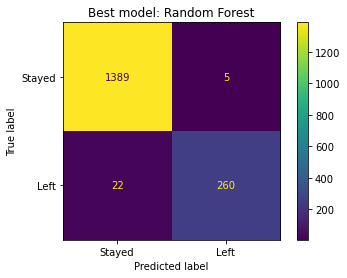

In [217]:
# Compute values for confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)

# Create display of confusion matrix using ConfusionMatrixDisplay()
disp_cm_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['Stayed', 'Left'])

# Plot confusion matrix
disp_cm_best.plot(values_format='d')
plt.title('Best model: Random Forest')

In [221]:
 best_results = model_evaluator('Random Forest (best)', y_test, y_pred_best, y_proba_best)

In [223]:
final_table = pd.concat([final_table, best_results]).sort_values(by='Recall', ascending=False)
final_table

,Model,Recall,Auc,F1,Precision,Accuracy
0,Random Forest (best),0.921986,0.983269,0.950640,0.981132,0.983890
0,Random Forest,0.915742,0.974462,0.951062,0.989372,0.984136
0,Logistic scaled,0.908127,0.896981,0.641698,0.496139,0.828657


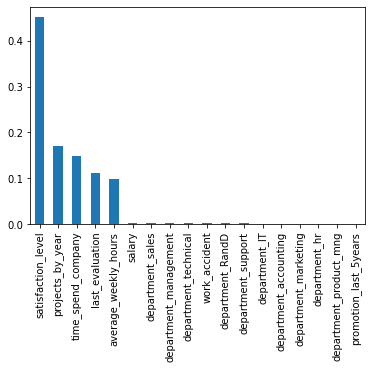

In [225]:
importances = rf_cv.best_estimator_.feature_importances_

best_importances = pd.Series(importances, index=X_final.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
best_importances.plot.bar(ax=ax)

### Summary of model results

- The Random Forest model achieved 92.2 % recall on the test set, accurately identifying 9 out of 10 employees who left; all other metrics (accuracy, precision, F1) exceeded 98%.
- Key predictors included satisfaction level, projects per year, tenure, last evaluation, and working hours. Overworked employees with low satisfaction were more likely to leave.


### Conclusion, Recommendations, Next Steps

1. Recommendations to reduce turnover:
 + Trigger alerts when satisfaction drops below 0.5; reduce working hours for those exceeding 200/month.
 + Base promotions on tenure and project relevance, especially near the 4-year mark, not just workload.
 + Rebalance workloads—employees with only 1 project showed higher attrition than those with 2–4.

2. The Random Forest model significantly outperformed logistic regression, with recall of 92.2 %, precision of 98.11 %, and accuracy of 98.4 %. It captured complex interactions between variables like project count, satisfaction level, tenure, last evaluation score and working hours. This model was selected due to its superior ability to detect at-risk employees.

3. Next steps:
- Deploy the model internally to support HR decision-making. Retention strategies should be prioritized for high-risk individuals, particularly those in low satisfaction categories and long working hours.
- Test the model’s robustness by excluding evaluation score and satisfaction level  to ensure no data leakage or reverse causality.
- Future iterations may incorporate additional features such as employee feedback and external job market data to enhance predictive power.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.